# Pipeline for High-z Radio Galaxies 16: AGN/Galaxy classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
# from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(stretch=PowerStretch(0.35))

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title, fontsize=14)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

Get estimators list

In [13]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

***

## Reading data

In [14]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [15]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [16]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [17]:
mqc_version = '7_4d'  # '7_2'

In [18]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [19]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag',\
                     'W2mag', 'spCl', 'FUVmag', 'NUVmag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [20]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard).sample(frac=0.1, random_state=42)

In [21]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [22]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [23]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 8248 elements,
2829 of them are marked as AGN, and 5419 are identified as galaxies.


---

## Possible correlations

In [24]:
print(full_catalog_df.columns.to_list())

['band_num', 'is_str', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

## Random seed

In [25]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [26]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [27]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str'])

## Split data: Test, Train, Validation

In [28]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2, random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (8248, 80)
Data for Modeling (Train and Test): (6598, 80)
Unseen Data For Validation: (1650, 80)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [29]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_01.txt', X=val_idx, header='Indices from first AGN training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [30]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [31]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [32]:
rsd_vals

K_W3        1174.778520
z_y          238.495686
i_z          195.047705
class        138.415647
i_y          125.156900
r_i          114.387882
y_W2         112.974183
g_r           94.460067
r_z           87.484511
y_W1          87.321957
z_W2          84.961269
r_y           80.168118
g_i           74.213293
z_W1          72.052509
g_z           68.953506
H_W3          68.409324
i_W2          68.373560
g_y           67.188051
i_W1          63.307575
r_W1          58.017484
r_W2          55.508068
g_W1          52.109576
J_W3          51.203085
y_J           47.330915
g_W2          46.267355
W1_W3         43.331395
y_H           42.924503
z_J           41.660127
J_H           39.459900
i_J           38.576762
z_H           38.061769
y_K           37.521069
r_J           37.084919
y_W3          35.505668
i_H           35.491489
r_H           34.619574
g_J           34.407118
z_K           33.937305
H_K           32.987179
W2_W3         32.635045
g_H           32.566577
i_K           32

In [33]:
correlation = norm_train_test_df.corr()

In [34]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [35]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [36]:
target_feat = 'class'

In [37]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [38]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [39]:
list_drop_corr

['g_H',
 'r_H',
 'y_H',
 'i_H',
 'z_H',
 'J_W1',
 'J_W2',
 'g_K',
 'r_K',
 'gmag',
 'y_K',
 'i_K',
 'z_K',
 'rmag',
 'ymag',
 'imag',
 'zmag',
 'K_W1',
 'W1mproPM',
 'J_W3',
 'K_W2',
 'g_W4',
 'W2mproPM',
 'Jmag',
 'r_W4',
 'J_W4',
 'y_W4',
 'i_W4',
 'g_W2',
 'z_W4',
 'g_W3',
 'H_W1',
 'W1_W4',
 'r_W3',
 'H_W2',
 'W2_W4',
 'r_W2',
 'y_W3',
 'i_W3',
 'z_W3',
 'g_y',
 'W3mag',
 'H_W3',
 'J_K',
 'g_z',
 'Kmag',
 'i_J',
 'z_J',
 'i_W1',
 'y_W1',
 'Hmag',
 'W2_W3',
 'z_W1',
 'g_W1',
 'g_J',
 'i_W2',
 'z_W2',
 'W3_W4',
 'K_W4',
 'r_y',
 'g_i',
 'band_num',
 'r_J']

In [40]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [41]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [42]:
corr_discard = norm_train_test_discard.corr()

In [43]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

W4mag  W4mag    1.000000
W1_W2  class    0.799841
H_K    H_W4     0.741769
r_z    r_i      0.728600
y_J    y_W2     0.689978
r_W1   r_z      0.666369
W4mag  K_W3     0.621007
r_W1   r_i      0.611646
z_y    i_y      0.599698
W1_W3  W1_W2    0.574173
i_y    i_z      0.564384
W1_W3  y_J      0.557033
r_z    W1_W2    0.516508
W1_W2  r_W1     0.514986
class  r_z      0.513949
dtype: float64

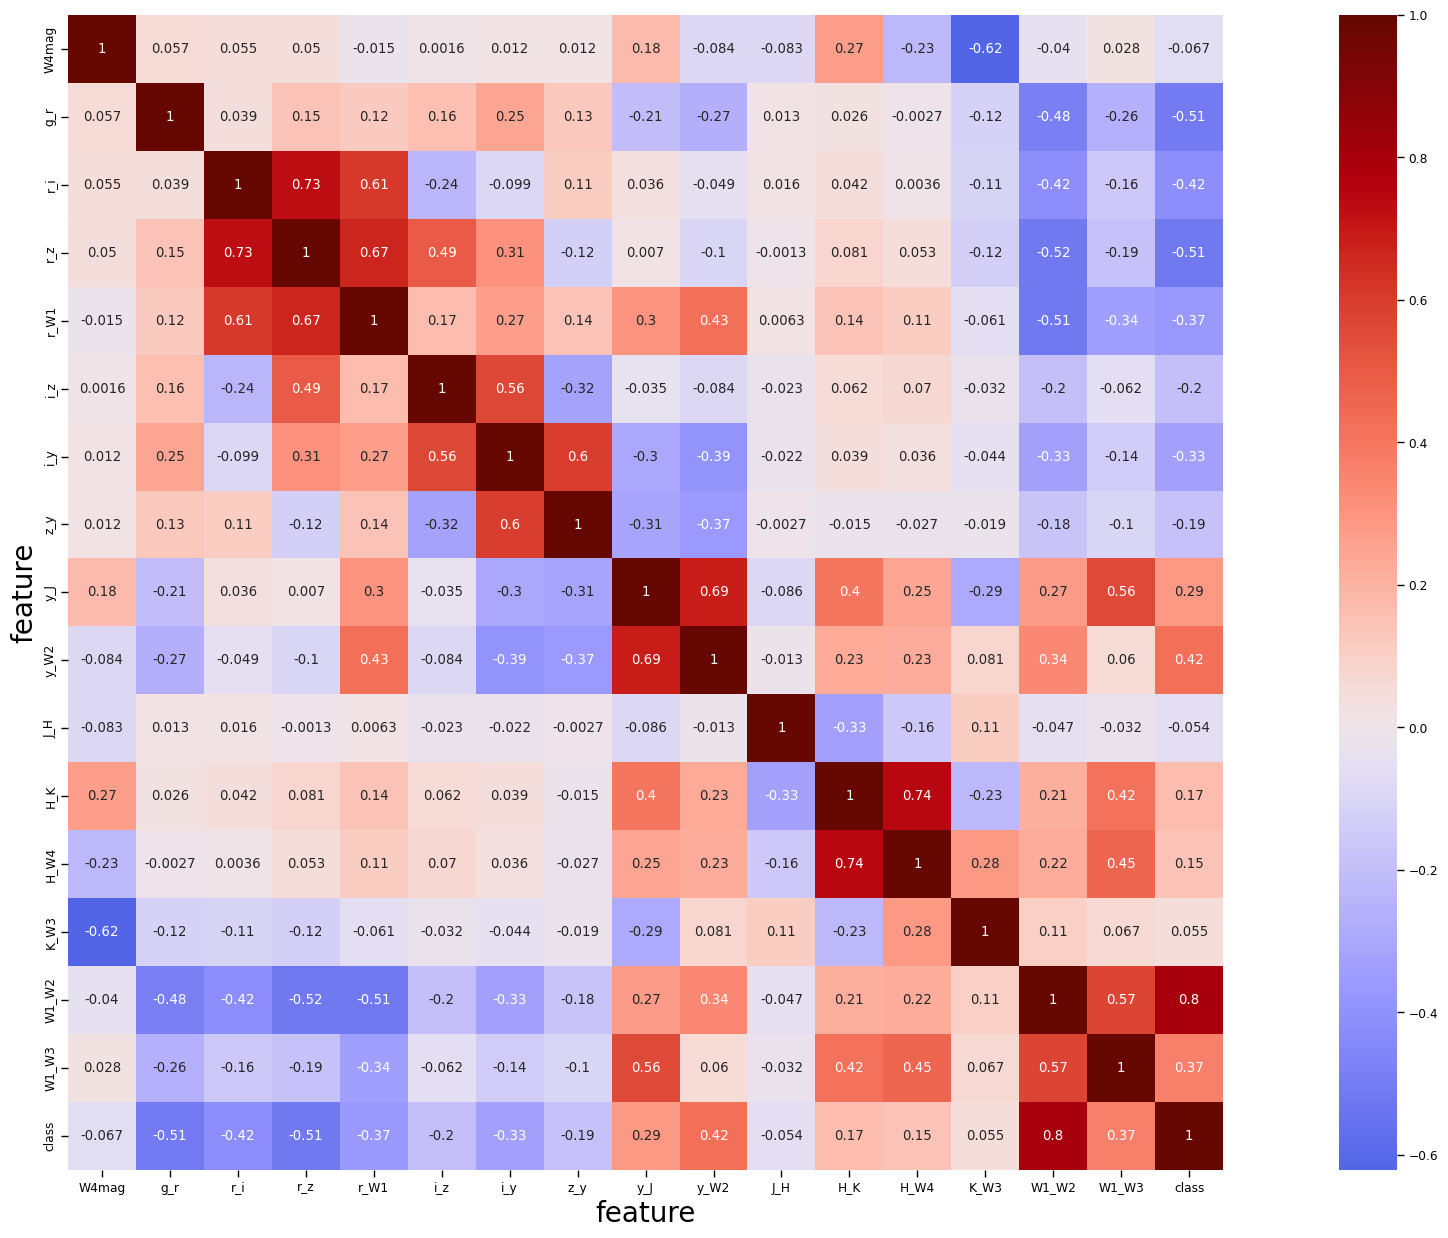

In [44]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')
plt.show()

In [45]:
norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [46]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [47]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x      y    
H_K    H_K      1.000000
W1_W2  class    0.721176
H_W4   H_K      0.653932
g_r    class    0.557460
r_i    class    0.496614
class  W1_W2    0.496286
r_z    class    0.488381
r_i    r_z      0.382764
r_z    r_i      0.366930
J_H    H_K      0.329757
H_K    H_W4     0.264731
i_y    class    0.252820
y_W2   class    0.251931
class  r_z      0.248731
       g_r      0.244526
r_W1   class    0.212046
i_z    class    0.210258
y_W2   y_J      0.203524
W1_W3  class    0.202978
class  r_i      0.202907
dtype: float64

In [48]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [49]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [50]:
target_feat = 'class'

In [51]:
list_drop_pps = []

In [52]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [53]:
list_drop_pps

[]

In [54]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [55]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=seed)

In [56]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,W1_W2,class,0.721176,classification,True,weighted F1,0.5592,0.877094,DecisionTreeClassifier()
1,g_r,class,0.557460,classification,True,weighted F1,0.5592,0.804928,DecisionTreeClassifier()
2,r_i,class,0.496614,classification,True,weighted F1,0.5592,0.778108,DecisionTreeClassifier()
3,r_z,class,0.488381,classification,True,weighted F1,0.5592,0.774478,DecisionTreeClassifier()
4,i_y,class,0.252820,classification,True,weighted F1,0.5592,0.670643,DecisionTreeClassifier()
5,y_W2,class,0.251931,classification,True,weighted F1,0.5592,0.670251,DecisionTreeClassifier()
6,r_W1,class,0.212046,classification,True,weighted F1,0.5592,0.652670,DecisionTreeClassifier()
7,i_z,class,0.210258,classification,True,weighted F1,0.5592,0.651882,DecisionTreeClassifier()
8,W1_W3,class,0.202978,classification,True,weighted F1,0.5592,0.648673,DecisionTreeClassifier()
9,y_J,class,0.150762,classification,True,weighted F1,0.5592,0.625656,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [57]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [58]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [59]:
exp_AGN = pyc.setup(data=train_test_df, target='class', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6598, 80)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [60]:
pyc.get_config('X').columns

Index(['W4mag', 'g_r', 'r_i', 'r_z', 'r_W1', 'i_z', 'i_y', 'z_y', 'y_J',
       'y_W2', 'J_H', 'H_K', 'H_W4', 'K_W3', 'W1_W2', 'W1_W3'],
      dtype='object')

In [61]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [62]:
metric_to_optimize   = 'Recall'

In [63]:
# final_selection_clf  = ['catboost', 'lightgbm', 'xgboost', 'lda', 'et', 'dummy']  # knn, qda, nb lack feat importances neither coefs, ridge lacks scores
final_selection_clf  = ['catboost', 'lr', 'gbc', 'svm', 'rf', 'dummy']  # knn, qda, nb lack feat importances neither coefs, ridge lacks scores
n_models             = 5
# top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_to_optimize)  # 1:15 hour for used_models_clf
top_model_AGN = pyc.compare_models(n_select=n_models,\
                                   exclude=['knn', 'qda', 'ridge', 'nb', 'lightgbm', 'lda', 'lr', 'xgboost'], sort=metric_to_optimize)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9517,0.9865,0.9205,0.9380,0.9288,0.8923,0.8928,0.6000
gbc,Gradient Boosting Classifier,0.9480,0.9847,0.9173,0.9307,0.9237,0.8843,0.8847,0.1650
ada,Ada Boost Classifier,0.9446,0.9795,0.9129,0.9246,0.9186,0.8766,0.8768,0.0480
et,Extra Trees Classifier,0.9476,0.9835,0.9110,0.9350,0.9226,0.8830,0.8835,0.0410
rf,Random Forest Classifier,0.9467,0.9835,0.9079,0.9354,0.9211,0.8809,0.8815,0.0750
svm,SVM - Linear Kernel,0.9329,0.0000,0.8977,0.9069,0.9017,0.8508,0.8514,0.1450
dt,Decision Tree Classifier,0.9253,0.9204,0.8914,0.8913,0.8912,0.8343,0.8345,0.2190
dummy,Dummy Classifier,0.6570,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0040


Thus, we select `catboost` as meta learner.

Then, we stack the models.

In [64]:
meta_model = top_model_AGN[0]

In [65]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=meta_model,\
                                     optimize=metric_to_optimize, restack=True)  # Do not use 'lr' for this test (already calibrated)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9545,0.9911,0.9557,0.9152,0.9350,0.9001,0.9006
1,0.9654,0.9916,0.9494,0.9494,0.9494,0.9231,0.9231
2,0.9416,0.9858,0.8861,0.9396,0.9121,0.8683,0.8692
3,0.9545,0.9903,0.9304,0.9363,0.9333,0.8989,0.8989
4,0.9545,0.9817,0.9245,0.9423,0.9333,0.8989,0.8989
5,0.9459,0.9836,0.9182,0.9241,0.9211,0.8800,0.8800
6,0.9329,0.9789,0.9182,0.8902,0.9040,0.8525,0.8527
7,0.9524,0.9812,0.9057,0.9536,0.9290,0.8932,0.8939
8,0.9544,0.9849,0.9557,0.9152,0.9350,0.9000,0.9005


In [66]:
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping='asha', optimize=metric_to_optimize,\
                               search_library='tune-sklearn', search_algorithm='bayesian')  # 20  minutes

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9589,0.9909,0.9557,0.9264,0.9408,0.9093,0.9096
1,0.9610,0.9907,0.9494,0.9375,0.9434,0.9137,0.9137
2,0.9394,0.9862,0.8924,0.9276,0.9097,0.8641,0.8645
3,0.9567,0.9888,0.9494,0.9259,0.9375,0.9044,0.9046
4,0.9545,0.9836,0.9308,0.9367,0.9338,0.8992,0.8992
5,0.9416,0.9835,0.9119,0.9177,0.9148,0.8703,0.8704
6,0.9351,0.9837,0.9182,0.8957,0.9068,0.8570,0.8572
7,0.9567,0.9795,0.9182,0.9542,0.9359,0.9032,0.9036
8,0.9523,0.9848,0.9684,0.9000,0.9329,0.8960,0.8974


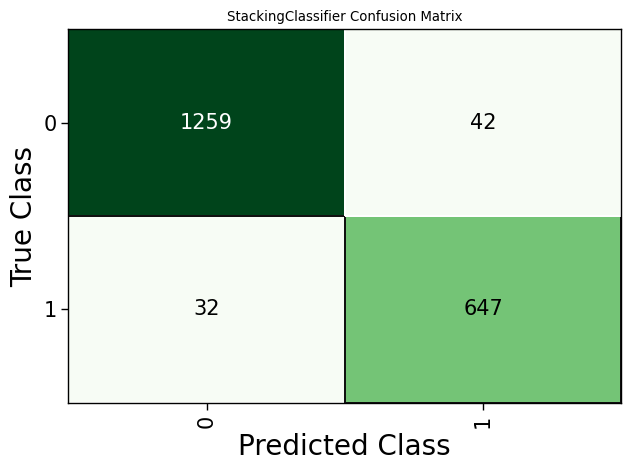

In [67]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

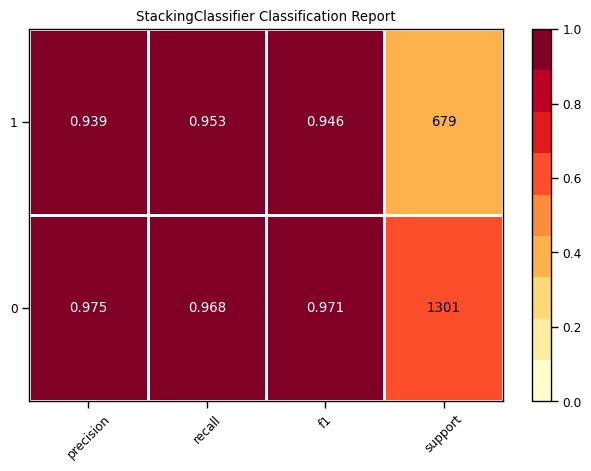

In [68]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

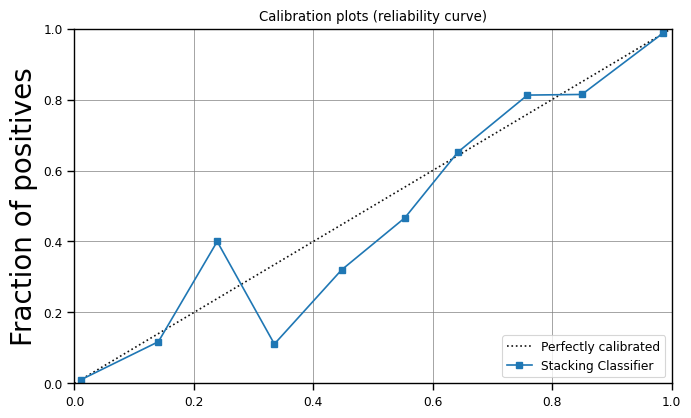

In [69]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

In [70]:
pyc.plot_model(tuned_AGN_clf, plot='parameter')

,Parameters
cv,5
estimators,"[('gbc', GradientBoostingClassifier(ccp_alpha=..."
final_estimator,<catboost.core.CatBoostClassifier object at 0x...
n_jobs,12
passthrough,True
stack_method,auto
verbose,0


In [71]:
plt.rcParams.update(plt.rcParamsDefault)

In [72]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9626,0.9903,0.9529,0.9390,0.9459,0.9174,0.9174


,Score_0,Score_1
count,1980.000000,1980.000000
mean,0.652843,0.347157
std,0.438388,0.438388
min,0.005500,0.005400
25%,0.045200,0.009300
50%,0.979000,0.021000
75%,0.990700,0.954800
max,0.994600,0.994500


In [73]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9626,0.9903,0.9529,0.9390,0.9459,0.9174,0.9174


In [74]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

In [75]:
calibrated_final_AGN_clf = CalibratedClassifierCV(base_estimator=final_AGN_clf, method='sigmoid', cv='prefit')
calibrated_final_AGN_clf.fit(pyc.get_config('X'), pyc.get_config('y'))

CalibratedClassifierCV(base_estimator=StackingClassifier(cv=5,
                                                         estimators=[('gbc',
                                                                      GradientBoostingClassifier(ccp_alpha=0.0,
                                                                                                 criterion='friedman_mse',
                                                                                                 init=None,
                                                                                                 learning_rate=0.1,
                                                                                                 loss='deviance',
                                                                                                 max_depth=3,
                                                                                                 max_features=None,
                                                             

In [76]:
pyc.predict_model(calibrated_final_AGN_clf, probability_threshold=0.5, raw_score=True).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9990,1.0000,0.9971,1.0000,0.9985,0.9978,0.9978


,Score_0,Score_1
count,1980.000000,1980.000000
mean,0.656892,0.343108
std,0.472872,0.472872
min,0.000100,0.000300
25%,0.000100,0.000300
50%,0.999600,0.000400
75%,0.999700,0.999900
max,0.999700,0.999900


In [82]:
non_cal_preds = pyc.predict_model(final_AGN_clf,            data=train_test_df, probability_threshold=0.5, raw_score=True)
cal_preds     = pyc.predict_model(calibrated_final_AGN_clf, data=train_test_df, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9976,1.0000,0.9938,0.9991,0.9965,0.9946,0.9946


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9979,1.0000,0.9951,0.9987,0.9969,0.9953,0.9953


In [101]:
min_non_cal                     = non_cal_preds.loc[:, 'Score_1'].min()
max_non_cal                     = non_cal_preds.loc[:, 'Score_1'].max()
min_cal                         = cal_preds.loc[:, 'Score_1'].min()
max_cal                         = cal_preds.loc[:, 'Score_1'].max()
min_max_scaler_cal              = MinMaxScaler(feature_range=(min_cal, max_cal))
min_max_scaler_cal.fit([non_cal_preds.loc[:, 'Score_1'].values])

MinMaxScaler(copy=True, feature_range=(0.0003, 0.9999))

In [91]:
pyc.predict_model(calibrated_final_AGN_clf, data=validation_df, probability_threshold=0.5, raw_score=True).loc[:, 'Score_1'].values.shape

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9576,0.9860,0.9435,0.9336,0.9385,0.9061,0.9061


(1650,)

In [96]:
pred_val = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9594,0.9860,0.9417,0.9400,0.9409,0.9099,0.9099


In [97]:
pred_val.loc[:, 'Score_1'].max(axis=0)

0.9945

In [100]:
len(min_max_scaler_cal.data_range_)

6598

In [102]:
cal_cal    = min_max_scaler_cal.transform([pred_val.loc[:, 'Score_1'].values])
# cal_cal_df = pd.DataFrame(data=cal_cal.T, columns=['Score_1'], index=train_test_df.index)

ValueError: operands could not be broadcast together with shapes (1,1650) (6598,) (1,1650) 

In [79]:
pyc.predict_model(calibrated_final_AGN_clf, data=train_test_df, probability_threshold=0.5, raw_score=True).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9979,1.0000,0.9951,0.9987,0.9969,0.9953,0.9953


,Score_0,Score_1
count,6598.000000,6598.000000
mean,0.657026,0.342974
std,0.472530,0.472530
min,0.000100,0.000300
25%,0.000100,0.000300
50%,0.999600,0.000400
75%,0.999700,0.999900
max,0.999700,0.999900


In [85]:
cal_cal_df.describe()

,Score_1
count,6.598000e+03
mean,3.000000e-04
std,1.606127e-17
min,3.000000e-04
25%,3.000000e-04
50%,3.000000e-04
75%,3.000000e-04
max,3.000000e-04


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9976,1.0000,0.9938,0.9991,0.9965,0.9946,0.9946


(array([4.071e+03, 1.130e+02, 3.100e+01, 2.400e+01, 1.500e+01, 1.300e+01,
        1.200e+01, 6.000e+00, 5.000e+00, 7.000e+00, 7.000e+00, 3.400e+01,
        4.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 5.000e+00,
        7.000e+00, 8.000e+00, 8.000e+00, 1.900e+01, 1.200e+01, 2.200e+01,
        3.800e+01, 5.200e+01, 7.400e+01, 1.190e+02, 2.390e+02, 1.644e+03]),
 array([0.0048    , 0.03782333, 0.07084667, 0.10387   , 0.13689333,
        0.16991667, 0.20294   , 0.23596333, 0.26898667, 0.30201   ,
        0.33503333, 0.36805667, 0.40108   , 0.43410333, 0.46712667,
        0.50015   , 0.53317333, 0.56619667, 0.59922   , 0.63224333,
        0.66526667, 0.69829   , 0.73131333, 0.76433667, 0.79736   ,
        0.83038333, 0.86340667, 0.89643   , 0.92945333, 0.96247667,
        0.9955    ]),
 <BarContainer object of 30 artists>)

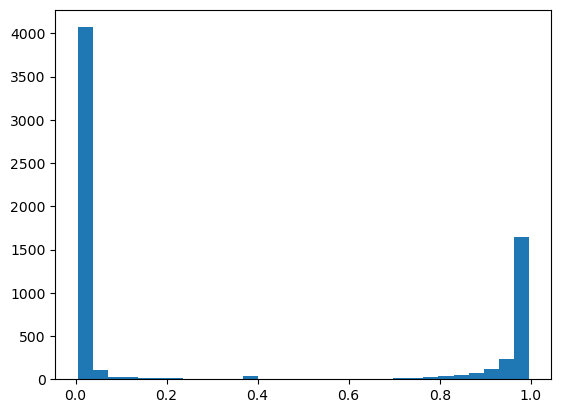

In [81]:
plt.hist(pyc.predict_model(final_AGN_clf, data=train_test_df,\
                                         probability_threshold=0.5, raw_score=True).loc[:, 'Score_1'], bins=30)

In [76]:
if save_model_flag:
    pyc.save_model(calibrated_final_AGN_clf, 'models/classification_AGN_galaxy_ago_03_2022')  # Model (it will be saved with .pkl extension) classification_AGN_galaxy_may_15_2022
    # pyc.save_config('../../models/config_classification_AGN_galaxy_ago_03_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [119]:
if load_model_flag:
    if use_5sigma:
        calibrated_final_AGN_clf = pyc.load_model('models/classification_AGN_galaxy_ago_03_2022')

Transformation Pipeline and Model Successfully Loaded


Use the calibrated stacking model only

In [130]:
used_final_AGN_clf = calibrated_final_AGN_clf.base_estimator

### Prediction process

#### Feature importances

In [131]:
estimators_list = get_base_estimators_names(used_final_AGN_clf)

In [132]:
estimators_list

['gbc', 'svm', 'rf', 'xgboost']

In [133]:
extended_data_AGN = validation_df.loc[:, get_final_column_names(calibrated_final_AGN_clf, validation_df)].copy()
extended_idx_AGN  = extended_data_AGN.index
initial_cols_AGN  = extended_data_AGN.columns
extended_cols_AGN = extended_data_AGN.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_AGN = extended_cols_AGN.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [135]:
extended_data_AGN

,W4mag,g_r,r_i,r_z,r_J,r_W1,i_z,i_y,z_y,y_J,y_W2,J_H,H_K,H_W4,K_W3,W1_W2,W1_W3
6694110,14.62,0.429701,0.183599,0.646099,1.639799,1.558800,0.462500,0.390001,-0.072498,1.066198,0.602200,0.210001,0.65,2.62,0.552,-0.382999,1.493000
2696849,14.62,0.099998,1.920301,1.950100,5.750000,3.524002,0.029799,0.748699,0.718901,3.080999,0.721001,0.210001,0.65,2.62,-0.080,-0.134001,3.005999
5655359,14.62,0.404699,0.755701,0.837700,3.979500,2.730501,0.081999,0.538399,0.456400,2.685400,0.639400,0.210001,0.65,2.62,-0.080,-0.797001,2.028999
4820922,14.62,0.152300,0.293800,0.618299,3.988899,2.095901,0.324499,0.904699,0.580200,2.790400,1.182400,0.210001,0.65,2.62,-0.080,0.284998,2.672998
1270671,14.62,1.044100,0.524599,0.743099,1.758499,1.009501,0.218500,0.598902,0.380402,0.634998,-0.578001,0.210001,0.65,2.62,-0.080,-0.464001,1.528999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967919,14.62,0.099998,1.830000,2.272902,5.750000,4.633001,0.442902,-0.029999,-0.472900,3.949999,2.160999,0.210001,0.65,2.62,-0.080,-0.672001,1.896999
4843808,14.62,0.180101,0.146599,-0.817400,4.032598,1.352600,-0.963999,-0.063999,0.900000,3.949999,1.590000,0.210001,0.65,2.62,-0.080,0.320000,3.459999
480399,14.62,0.220100,0.075001,0.324100,3.363199,0.908201,0.249100,0.515999,0.266899,2.772200,0.849199,0.210001,0.65,2.62,-0.080,0.531998,3.234999
4877206,14.62,0.024801,0.185299,0.253799,3.513899,0.833900,0.068501,0.274601,0.206100,3.053999,0.694000,0.210001,0.65,2.62,-0.080,0.320000,3.459999


In [136]:
print('Running data pre-processing:\n')
if isinstance(calibrated_final_AGN_clf, sklearn.pipeline.Pipeline):
    prep_steps = calibrated_final_AGN_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_AGN = method.transform(extended_data_AGN)
extended_data_AGN_df = pd.DataFrame(extended_data_AGN, columns=extended_cols_AGN, index=extended_idx_AGN)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [137]:
extended_data_AGN_df

,xgboost,rf,svm,gbc,W4mag,g_r,r_i,r_z,r_J,r_W1,...,i_y,z_y,y_J,y_W2,J_H,H_K,H_W4,K_W3,W1_W2,W1_W3
6694110,NaN,NaN,NaN,NaN,0.203698,-0.483446,-0.562160,-0.178680,-1.386404,-0.296243,...,-0.115944,-0.560295,-1.181971,-0.231137,-0.056863,0.365249,0.181136,1.353660,-0.288776,-0.686469
2696849,NaN,NaN,NaN,NaN,0.203698,-0.928967,2.082607,1.653973,2.023756,1.292380,...,0.495024,0.996652,0.847599,-0.097773,-0.056863,0.365249,0.181136,-0.178984,0.333845,1.057332
5655359,NaN,NaN,NaN,NaN,0.203698,-0.517188,0.379055,0.103657,0.648089,0.707388,...,0.136747,0.489491,0.507580,-0.189443,-0.056863,0.365249,0.181136,-0.178984,-1.668348,-0.096839
4820922,NaN,NaN,NaN,NaN,0.203698,-0.858216,-0.373583,-0.220141,0.655663,0.191784,...,0.760900,0.729552,0.599895,0.426384,-0.056863,0.365249,0.181136,-0.178984,1.079544,0.654001
1270671,NaN,NaN,NaN,NaN,0.203698,0.342817,0.010732,-0.034963,-1.276958,-0.842799,...,0.239803,0.341231,-1.704520,-1.531070,-0.056863,0.365249,0.181136,-0.178984,-0.527033,-0.647680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967919,NaN,NaN,NaN,NaN,0.203698,-0.928967,1.956573,2.086126,2.023756,2.039617,...,-0.830599,-1.378456,1.536191,1.561665,-0.056863,0.365249,0.181136,-0.178984,-1.210839,-0.244737
4843808,NaN,NaN,NaN,NaN,0.203698,-0.820619,-0.626123,-2.471426,0.690826,-0.496409,...,-0.888426,1.342894,1.536191,0.896065,-0.056863,0.365249,0.181136,-0.178984,1.131779,1.619732
480399,NaN,NaN,NaN,NaN,0.203698,-0.766540,-0.750763,-0.665346,0.142098,-0.947997,...,0.098597,0.118331,0.584009,0.046890,-0.056863,0.365249,0.181136,-0.178984,1.426489,1.339362
4877206,NaN,NaN,NaN,NaN,0.203698,-1.030735,-0.559229,-0.773276,0.267720,-1.025956,...,-0.312373,-0.001905,0.825024,-0.128139,-0.056863,0.365249,0.181136,-0.178984,1.131779,1.619732


In [110]:
calibrated_final_AGN_clf.calibrated_classifiers_[0].base_estimator.estimators_

[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=42, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='hinge',
               max_iter=1000, n_iter_no_change=5, n_jobs=12, penalty='l2',
     

In [137]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    if hasattr(final_AGN_clf.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_AGN_clf.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_AGN_clf.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_AGN_clf.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_AGN.loc[:, extended_cols_AGN].std(axis=0)
else:
    if hasattr(calibrated_final_AGN_clf.calibrated_classifiers_[0].base_estimator.final_estimator_, 'feature_importances_'):
        importances_coef = calibrated_final_AGN_clf.calibrated_classifiers_[0].base_estimator.final_estimator_.feature_importances_
    elif hasattr(calibrated_final_AGN_clf.calibrated_classifiers_[0].base_estimator.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(calibrated_final_AGN_clf.calibrated_classifiers_[0].base_estimator.final_estimator_.coef_)) *\
                                     extended_data_AGN.loc[:, extended_cols_AGN].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_AGN, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [139]:
coef_sorted_meta_df

,Feature,Importance
0,svm,40.964334
1,lr,17.109653
2,rf,12.538026
3,W1_W3,5.862911
4,r_J,5.014920
5,H_K,4.223978
6,r_W1,3.234833
7,g_r,3.110710
8,gbc,1.899405
9,y_J,1.856557


In [126]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_AGN_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_AGN_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = calibrated_final_AGN_clf.calibrated_classifiers_[0].base_estimator.estimators
    # estimators_list_ = final_AGN_clf.base_estimator.estimators_
    estimators_list_ = [estimator_tmp[1] for estimator_tmp in estimators_list]

In [127]:
base_models_names = [model[0] for model in estimators_list]

In [128]:
coef_sorted_base_df = {}

In [129]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_AGN.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
        )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                     'Importance': np.abs(model_fit.coef_.ravel()) *\
                                     extended_data_AGN_df.loc[:, extended_cols_AGN.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_AGN.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
        )

In [130]:
coef_sorted_base_df

{}

In [131]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [132]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_base_full_df)

Feature importances scaled to sum 100


ValueError: No objects to concatenate

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, cate

In [ ]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
with pd.option_context('display.float_format', '{:.4e}'.format):
    display(coef_sorted_meta_df_copy_sum)

In [ ]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_AGN_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_AGN_galaxy_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

---

In [ ]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['class']), train_test_df.loc[:, 'class'], False, 'class'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['class']),
                train_test_df.loc[:, 'class'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

#### Calculate optimal threshold for classification

In [ ]:
AGN_naive_threshold       = 0.5

In [ ]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_data_df,  probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)

#### Naive threshold metrics.

In [ ]:
cm_mat_val_naive = np.array([[np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                             [np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

In [ ]:
cm_mat_train_naive = np.array([[np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                               [np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [ ]:
cm_mat_test_naive = np.array([[np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

In [ ]:
cm_mat_train_test_naive = np.array([[np.sum(np.array(train_test_prediction_clf['class'] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf['class'] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                                    [np.sum(np.array(train_test_prediction_clf['class'] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf['class'] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

In [ ]:
MCC_val_naive           = MCC_from_CM(cm_mat_val_naive)
ACC_val_naive           = ACC_from_CM(cm_mat_val_naive)
F1_val_naive            = F1_from_CM(cm_mat_val_naive)
Recall_val_naive        = Recall_from_CM(cm_mat_val_naive)

MCC_train_naive         = MCC_from_CM(cm_mat_train_naive)
ACC_train_naive         = ACC_from_CM(cm_mat_train_naive)
F1_train_naive          = F1_from_CM(cm_mat_train_naive)
Recall_train_naive      = Recall_from_CM(cm_mat_train_naive)

MCC_test_naive          = MCC_from_CM(cm_mat_test_naive)
ACC_test_naive          = ACC_from_CM(cm_mat_test_naive)
F1_test_naive           = F1_from_CM(cm_mat_test_naive)
Recall_test_naive       = Recall_from_CM(cm_mat_test_naive)

MCC_train_test_naive    = MCC_from_CM(cm_mat_train_test_naive)
ACC_train_test_naive    = ACC_from_CM(cm_mat_train_test_naive)
F1_train_test_naive     = F1_from_CM(cm_mat_train_test_naive)
Recall_train_test_naive = Recall_from_CM(cm_mat_train_test_naive)

naive_scores_array            = np.array([[F1_train_naive,      MCC_train_naive,      Recall_train_naive,      ACC_train_naive],\
                                          [F1_test_naive,       MCC_test_naive,       Recall_test_naive,       ACC_test_naive],\
                                          [F1_train_test_naive, MCC_train_test_naive, Recall_train_test_naive, ACC_train_test_naive],\
                                          [F1_val_naive,        MCC_val_naive,        Recall_val_naive,        ACC_val_naive]])

In [ ]:
naive_scores_df = pd.DataFrame(data=naive_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [ ]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df)

#### Calibration curve

In [ ]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, 'class'],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, 'class'],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

In [ ]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='s', c='k', lw=2.5)
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

Calculate ROC AUC values and plots.

In [ ]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'class'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'class'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, 'class'], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'class'], validation_prediction_clf.loc[:, 'Score_1'])

In [ ]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

In [ ]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, 'class'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, 'class'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, 'class'], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, 'class'], validation_prediction_clf.loc[:, 'Score_1'])

In [ ]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test. (AUC = {roc_auc_train_test:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='AGN/Galaxy\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

##### Find optimal threshold for each sub-set

In [ ]:
opt_t_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_t_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_t_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_t_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [ ]:
print(f'Optimal threshold from area under the curve (ROC) for training   = {opt_t_train:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for test       = {opt_t_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for train+test = {opt_t_train_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for validation = {opt_t_validation:.5f}')

##### Precision-Recall curve

In [ ]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, 'class'],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, 'class'],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, 'class'],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, 'class'],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [ ]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_validation = auc(recall_validation, prec_validation)

In [ ]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test (AUC = {auc_pr_train_test:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, 'class'] == 1)      / len(train_prediction_clf.loc[:, 'class'])
no_skill_test       = np.sum(test_prediction_clf.loc[:, 'class'] == 1)       / len(test_prediction_clf.loc[:, 'class'])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, 'class'] == 1) / len(train_test_prediction_clf.loc[:, 'class'])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, 'class'] == 1) / len(validation_prediction_clf.loc[:, 'class'])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='AGN/Galaxy\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/PR_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [ ]:
fscore_train      = (2 * prec_train      * recall_train)      / (prec_train      + recall_train)
fscore_test       = (2 * prec_test       * recall_test)       / (prec_test       + recall_test)
fscore_train_test = (2 * prec_train_test * recall_train_test) / (prec_train_test + recall_train_test)
fscore_validation = (2 * prec_validation * recall_validation) / (prec_validation + recall_validation)

In [ ]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [ ]:
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation:.5f}')

---

In [ ]:
AGN_pred_threshold = float(opt_t_PR_train_test) #  0.46759

In [ ]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_pred_threshold, raw_score=True)
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_data_df,  probability_threshold=AGN_pred_threshold, raw_score=True)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df, probability_threshold=AGN_pred_threshold, raw_score=True)

Create confusion matrices.

In [ ]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                         [np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                        [np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

cm_mat_train_test = np.array([[np.sum(np.array(train_test_prediction_clf['class'] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf['class'] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(train_test_prediction_clf['class'] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf['class'] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                       [np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

In [ ]:
MCC_gal_AGN_train    = MCC_from_CM(cm_mat_train)
ACC_gal_AGN_train    = ACC_from_CM(cm_mat_train)
F1_gal_AGN_train     = F1_from_CM(cm_mat_train)
Recall_gal_AGN_train = Recall_from_CM(cm_mat_train)

MCC_gal_AGN_test    = MCC_from_CM(cm_mat_test)
ACC_gal_AGN_test    = ACC_from_CM(cm_mat_test)
F1_gal_AGN_test     = F1_from_CM(cm_mat_test)
Recall_gal_AGN_test = Recall_from_CM(cm_mat_test)

MCC_gal_AGN_train_test    = MCC_from_CM(cm_mat_train_test)
ACC_gal_AGN_train_test    = ACC_from_CM(cm_mat_train_test)
F1_gal_AGN_train_test     = F1_from_CM(cm_mat_train_test)
Recall_gal_AGN_train_test = Recall_from_CM(cm_mat_train_test)

MCC_gal_AGN_val    = MCC_from_CM(cm_mat_val)
ACC_gal_AGN_val    = ACC_from_CM(cm_mat_val)
F1_gal_AGN_val     = F1_from_CM(cm_mat_val)
Recall_gal_AGN_val = Recall_from_CM(cm_mat_val)

final_scores_array      = np.array([[F1_gal_AGN_train,      MCC_gal_AGN_train,      Recall_gal_AGN_train,      ACC_gal_AGN_train],\
                                    [F1_gal_AGN_test,       MCC_gal_AGN_test,       Recall_gal_AGN_test,       ACC_gal_AGN_test],\
                                    [F1_gal_AGN_train_test, MCC_gal_AGN_train_test, Recall_gal_AGN_train_test, ACC_gal_AGN_train_test],\
                                    [F1_gal_AGN_val,        MCC_gal_AGN_val,        Recall_gal_AGN_val,        ACC_gal_AGN_val]])

In [ ]:
final_scores_df = pd.DataFrame(data=final_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [ ]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(final_scores_df)

In [ ]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()